In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import csv

### Data Loader

In [2]:
csv_file_path = '../parsed_data.csv'
parsed_data = []
parsed_signal_data = []
with open(csv_file_path, 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    
    for row in csv_reader:
        data_point = [float(value) for value in row]
        parsed_data.append(data_point)

print(len(parsed_data))

with open("../parsed_signal_data.csv", 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    
    for row in csv_reader:
        data_point = [float(value) for value in row]
        parsed_signal_data.append(data_point)

print(len(parsed_signal_data))

350181
53000


### First Round of Adjustment

Idea is to add more nodes and more layers to increase complexity, lose some genearlization but gain a lot more accuracy. To counteract overfitting, we will increase batch size to help.

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available, CPU used')


GPU is available


In [25]:
from sklearn.model_selection import train_test_split

tensor_data = torch.tensor(parsed_data, dtype=torch.float)
train_data, val_data = train_test_split(tensor_data, test_size=0.2, random_state=42)
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)
batch_size = 1024  # adjust later
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
model = AutoEncoder()
model.to(device)
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 


In [26]:
num_epochs = 20  # Number of training epochs
for epoch in range(num_epochs):
    # Training Phase
    model.train()  # Set the model to training mode
    train_loss = 0.0
    for data in train_dataloader:
        inputs = data[0].to(device)  # Assuming data is a tuple of (input, target)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Calculate average training loss
    train_loss /= len(train_dataloader.dataset)

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Turn off gradients for validation
        for data in val_dataloader:
            inputs = data[0].to(device)  # Assuming data is a tuple of (input, target)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            val_loss += loss.item() * inputs.size(0)

    # Calculate average validation loss
    val_loss /= len(val_dataloader.dataset)

    # Print epoch summary
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1/20, Training Loss: 36883.5843, Validation Loss: 19769.9169
Epoch 2/20, Training Loss: 19589.5806, Validation Loss: 19548.2172
Epoch 3/20, Training Loss: 19567.2501, Validation Loss: 19546.8323
Epoch 4/20, Training Loss: 19562.3453, Validation Loss: 19531.2870
Epoch 5/20, Training Loss: 19318.4673, Validation Loss: 18803.4339
Epoch 6/20, Training Loss: 17990.0954, Validation Loss: 17854.0955
Epoch 7/20, Training Loss: 17883.3308, Validation Loss: 17852.3367
Epoch 8/20, Training Loss: 17882.5675, Validation Loss: 17851.9221
Epoch 9/20, Training Loss: 17882.3508, Validation Loss: 17851.8025
Epoch 10/20, Training Loss: 17882.3324, Validation Loss: 17851.9237
Epoch 11/20, Training Loss: 17882.2646, Validation Loss: 17851.7507
Epoch 12/20, Training Loss: 17882.2184, Validation Loss: 17851.6047
Epoch 13/20, Training Loss: 17882.1767, Validation Loss: 17851.5419
Epoch 14/20, Training Loss: 17882.1110, Validation Loss: 17851.5193
Epoch 15/20, Training Loss: 17882.0544, Validation Loss: 

In [22]:
model_save_path = "autoencoder_model_2_2.pth"
torch.save(model.state_dict(), model_save_path)

## Model Evaluation through Background Reconstruction Error & Signal Reconstruction Error

Iteration 1

In [29]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available, CPU used')

background_tensor_data = torch.tensor(parsed_data, dtype=torch.float)
background_dataset = TensorDataset(background_tensor_data)
background_dataloader = DataLoader(background_dataset, batch_size=8192, shuffle=False)

background_reconstruction_loss = []
model = AutoEncoder()  # Replace with your actual model class name
model.load_state_dict(torch.load('../model/autoencoder_model_2_2.pth', map_location=device))
model.to(device)
model.eval()
with torch.no_grad():
    for data in background_dataloader:
        inputs = data[0].to(device)
        reconstructed = model(inputs)
        error = torch.sum((inputs-reconstructed)**2, dim=1)
        background_reconstruction_loss.extend(error.cpu().numpy())

GPU is available


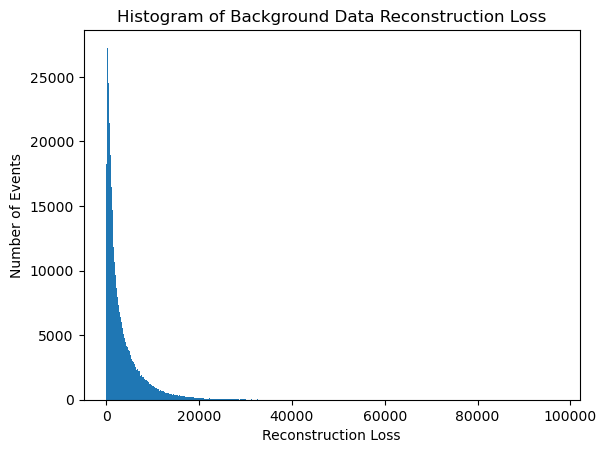

In [30]:
plt.hist(background_reconstruction_loss, bins=500)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Number of Events')
plt.title("Histogram of Background Data Reconstruction Loss")
plt.show()

In [31]:
max_error = max(background_reconstruction_loss)
min_error = min(background_reconstruction_loss)
print(max_error)
print(min_error)

97128.52
19.616138


In [32]:
sum = 0
for i in background_reconstruction_loss:
    sum += i

print(sum/len(background_reconstruction_loss))

3505.329828751807


#### Signal Reconstruction Error

In [33]:
signal_tensor_data = torch.tensor(parsed_signal_data, dtype=torch.float)
signal_dataset = TensorDataset(signal_tensor_data)
signal_dataloader = DataLoader(signal_dataset, batch_size=8192, shuffle=False)

signal_reconstruction_loss = []
with torch.no_grad():
    for data in signal_dataloader:
        inputs = data[0].to(device)
        reconstructed = model(inputs)
        error = torch.sum((inputs-reconstructed)**2, dim=1)
        signal_reconstruction_loss.extend(error.cpu().numpy())

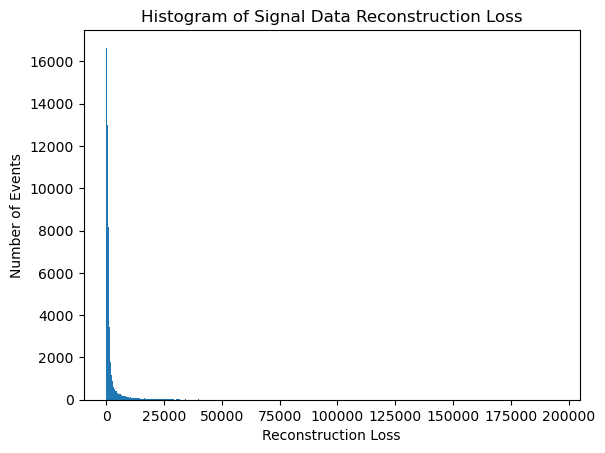

In [34]:
plt.hist(signal_reconstruction_loss, bins=500)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Number of Events')
plt.title("Histogram of Signal Data Reconstruction Loss")
plt.show()

In [35]:
max_error = max(signal_reconstruction_loss)
min_error = min(signal_reconstruction_loss)
print(max_error)
print(min_error)

194998.7
33.501213


In [36]:
sum = 0
for i in signal_reconstruction_loss:
    sum += i

print(sum/len(signal_reconstruction_loss))

2301.6197908532486
